# Analysis of Physical Oceanographic Data - SIO 221A
### Python version of [Sarah Gille's](http://pordlabs.ucsd.edu/sgille/sioc221a/index.html) notes by:
#### Bia Villas Bôas (avillasboas@ucsd.edu) & Gui Castelão (castelao@ucsd.edu)

## Lecture 10

*Reading:  Bendat and Piersol, Ch. 5.2.1*

**Recap**

Last time we looked at the sinc function, windowing, and detrending with an eye to
reducing edge effects in our spectra.
We've got a full recipe, but we stopped at a cliffhanger problem:  how many degrees
of freedom do we really have?

We'll try to sort this out today, along with venturing into Monte Carlo simulation.


**Windowing and overlapping segments**

So a quick recap.  When we filter, we convolve the filter with our
data in the time domain, which is equivalent to multiplying in the
frequency domain.  When we window, we multiply by a tapered window
in the time domain, which is equivalent to convolving in the frequency
domain.

How many degrees of freedom do you have for overlapping windows.  Not
$2\nu$ but close to that.  Bendat and Piersol usefully say that overlapping
by 50\% will recover about 90\% of the stability lost due to tapering.


The windowed spectra that we've discussed as a basic approach in class are
referred to by a number of names in the literature.  Some textbooks refer
to windowing as "tapering".  And the formal method is sometimes called
the Welch method.  Percival and Walden (*Spectral Analysis for
Physical Applications*, Cambridge University Press, 1993) provide
a detailed discussion of this approach under the name "Welch's Overlapping Segment Averaging (WOSA)".

Our overarching concern is that we adhere to Parseval's theorem.  Since the
window default normalization can reduce the variance, this will typically
require that we scale up appropriately
to conserve energy/variance (e.g. by $\sqrt{8/3}$ for
a Hanning window).  How do you find this scale factor?  One way is to
sum over a wide window.  For example:

```
N = 10000
print(np.sum(np.hanning(N)**2)/N, 3/8)
print(np.sum(np.hamming(N)8*2/N, 0.3974)
```

Will the window preserve energy in your system?  Not necessarily.  You can
normalize it appropriately, but windowing can shift the background energy
level of your spectrum relative to the spectral peaks,
and you'll want to keep track pay attention to the possibility of biases resulting from the windowing procedure.

**How many degrees of freedom do we have?**

Once you've created overlapping, windowed segments, then you'll need to
figure out how many independent segments you really have.  Clearly
at a minimum you should have the equivalent of the number of segments that
you would have if you did no overlapping.  If you have $N$ data points
divided into segments that are 2$M$ wide, then the minimum number of segments
is $N/(2M)$.  But with windowing, the end points of each segment are used
less than the middle, making the overlapping segments more independent, so perhaps we have more degrees of freedom.  Since the segments overlap by 50\%,
we probably can't treat them as being independent. Bendat and Piersol usefully say that overlapping by 50\% will recover about 90\% of the stability lost due to tapering.
How much does the use of overlapping segments modulate the degrees of freedom?

 If you look this up in the 2nd
edition of Emery and Thomson, you find a nice table (their Table 5.6.4),
ostensably lifted from Priestley. Priestley's results are nicely
discussed by Koopmans (*The Spectral Analysis of Time Series*,
Academic Press, 1974).  Emery and Thomson describe the table as representing
the equivalent degrees of freedom for windowed "block averaged" spectra.

A little further exploration of the literature shows that the values in Emery and Thomson's
table are incorrectly labeled and actually represent degrees of freedom
for spectra determined by filtering or averaging adjacent frequencies
from an initial spectral estimate.
If you filter in frequency, you can increase your degrees of freedom
just the way you increase degrees of freedom by using multiple segments.
And you can refine your filtering to reduce spectral ringing effects by
using a carefully constructed filter.  While people use the same types
of filters for time domain windowing/tapering and for frequency domain
filtering, the effect is not identical.  (If we wanted an identical effect,
we'd need to use the Fourier transform of the time domain window to filter
in the frequency domain.  You could do that, but it's not what we usually
envision when we talk about windowing or tapering, and it's not what Emery and
Thomson seem to describe.)  What this means is that the tables of "equivalent degrees of freedom" for the frequency domain don't actually work for windowed time domain data.

So at this point we have three options:

1. Abandon windowing and filter in the frequency domain, so that we can take advantage of the correct estimates of degrees of freedom.  This is a possibility, and we'll get to it, but it seems like we're unnecessarily giving up on the windowing approach that we've been exploring.

2. Use a brute strength approach - Monte Carlo simulation - to figure out how many degrees of freedom we have.

3. Find an analytic solution to decide how many degrees of freedom we have.

**Monte Carlo simulation:  How to avoid the traps imposed by standard statistical
assumptions (and how to fake your way as a statistician through computational inefficiency
rather than clever mathematics)**

Most of the time, we estimate spectral error bars using basic statistical assumptions --- that
data are normally distributed, that we have enough samples for the central limit theorem to
apply, that statistics are stationary.  These assumptions make our statistical models
tractable --- we end up with equations we can manipulate, allowing us (or clever statisticians
100 years ago) to derive simple equations that give us rules for how systems should behave.
But what happens when those assumptions break down?  Or what happens when we have little doubts
about the validity of the statistical model.  We can always resort to a Monte Carlo process.
In Monte Carlo methods, we throw theory on its head and use an empirical approach to generate
many realizations of our data set, with noise appropriate to our problem.

As an example, consider the problem of determining the standard error of the mean.
When we discussed it in class, we did a quick derivation to show that the standard
error of the mean is $\sigma/\sqrt{N}$, where $\sigma$ is the standard deviation and
$N$ is the effective degrees of freedom.  But what if I didn't trust this realization?
I could generate a large number of realizations of my data with noise typical of the real
data, compute means for each realization, and look at the statistics of those values.

So let's put this to work.  Suppose I'm computing the mean of $N=500$ data points.  With one
sample, I can compute the mean $\mu$ and standard deviation $\sigma$, and standard error
$\sigma/\sqrt{500}$.  But I might wonder
if $\mu$ is really representative.  So I can generate an ensemble of fake data, perhaps 100
data sets based on adding Gaussian white noise (or non-Gaussian white noise) to the real data.
Each of these data sets will have a mean $\mu_i$ and a standard deviation $\sigma_i$.  And I can
look at the standard deviation of all of the $\mu_i$ values.  I can also look at the pdf of
my $\mu_i$'s and other higher order statistics.
For example:

For example:

```
A = np.random.randn(500,100)
mu = A.mean(axis=0)
sigma_A = A.std(axis=0, ddof=1)
std_A = sigma_A/np.sqrt(500)

print(mu.std(), std_A.mean()) #compare standard deviation of means 
                              # vs standard error of the mean
```

Now we could expand on our example and ask, what if our noise were non-Gaussian or gappy
or had other problems, and we could adjust our Monte Carlo process appropriately.  And importantly, we can use this approach to test windowing strategies, by
generating fake data with a white spectrum (or a known red spectrum), windowing,
segmenting, and evaluating the statistics of the solution --- the standard deviation in log space --- relative to the formal error bar.

Now we could expand on our example and ask, what if our noise were non-Gaussian or gappy
or had other problems, and we could adjust our Monte Carlo process appropriately.  And importantly, we can use this approach to test windowing strategies, by
generating fake data with a white spectrum (or a known red spectrum), windowing,
segmenting, and evaluating the statistics of the solution---the standard deviation in log space---relative to the formal error bar.

**A more analytic approach to degrees of freedom for overlapping segments**

If the Monte Carlo approach seems too ad hoc, we can try something else.
 Percival and Walden provide a full derivation of the actual degrees of freedom for overlapping segments. They define the following terms:

$$\begin{eqnarray*}
N & = & \mbox{total length of record} \\
N_B & = & \mbox{number of blocks} \\
N_S & = & \mbox{segment length or block size} \\
n & = & \mbox{shift factor or number of points of overlap between segments} \\
h & = & \mbox{window, normalized so that $h^2$ sums to 1}.
\end{eqnarray*}$$

They point out that the covariance between adjacent segments determines
the adjustment to the degrees of freedom, and this depends on $h$.

In this framework, the variance of the spectral estimate is:


$$\begin{equation}
\mbox{var}\left\{\hat{S}^{(WOSA)}(f)\right\} =
\frac{1}{N_B} \sum_{j=0}^{N_B-1} \left(\mbox{var}\left\{\hat{S}_{jn+1}(f)\right\} +
\frac{2}{N_B} \sum_{j<k} \mbox{cov}\left\{\hat{S}_{jn+1}(f),\hat{S}_{kn+1}(f)\right\}\right),
\end{equation}$$


where $j$ and $k$ are indices for separate but overlapping segments.
The variance of the $j$th spectrum should converge to the canonical
spectrum:

The variance of the $j$th spectrum should converge to the canonical
spectrum:

$$\begin{equation}
\mbox{\rm var}\left\{\hat{S}_{jn+1}(f)\right\} \approx S^2(f).
\end{equation}$$

The covariance depends on the overlap of the tapers or windows:

$$\begin{equation}
\mbox{\rm cov}\left\{\hat{S}_{jn+1}(f),\hat{S}_{kn+1}(f)\right\} \approx S^2(f)
\left|\sum_{t=1}^{N_S} h_t h_{t+|k-j|n}\right|^2,
\end{equation}$$

with  $h_t$ defined to be zero when $t$ is out of range (i.e. $t>N_S$).
This means that:

$$\begin{eqnarray}
\mbox{\rm var}\left\{\hat{S}^{(WOSA)}(f)\right\} & \approx  &
S^2(f)\left(1+\frac{2}{N_B} \sum_{j<k}
\left|\sum_{t=1}^{N_S} h_t h_{t+|k-j|n}\right|^2\right)\\
& = &
S^2(f)\left(1+ 2\sum_{m=1}^{N_B-1} \left(1-\frac{m}{N_B}\right)
\left|\sum_{t=1}^{N_S} h_t h_{t+mn}\right|^2\right).
\end{eqnarray}
$$

Thus for a full record with arbitrary overlap:

$$\begin{equation}
\nu \approx \frac{2N_B}{1 + 2\sum_{m=1}^{N_b-1} \left(1-\frac{m}{N_B}\right)
\left|\sum_{t=1}^{N_S} h_t h_{t+mn}\right|^2}.
\end{equation}$$

This formulation allows for arbitrary levels of overlap, so you could
imagine starting a new segment every data point and having to contend
with with lots of complicated covariances between adjacent segments.

For practical purposes, we typically work with 50\% overlap, so $n=N_S/2$.
In this case, Percival and Walden show that the equation for the
effective degrees of freedom simplifies to

$$\begin{equation}
\nu \approx \frac{2N_B}{1 + 2\left(1-\frac{1}{N_B}\right)
\left|\sum_{t=1}^{N_S/2} h_t h_{t+N_S/2}\right|^2}.
\end{equation}$$

In the limit of large $N_B$ and many samples, it's relatively straightforward to find
an analytic solution:

$$\begin{equation}
\nu \approx \frac{2N_B}{1 + 2 \left|\int_0^{L/2} h(t) h(t+L/2)\, dt\right|^2}.
\end{equation}$$

subject to the requirement that the window normalization is:

$$\begin{equation}
\int_0^{L} h(t)^2 \, dt = 1.
\end{equation}$$

Thus for a boxcar filter, $h(t) = 1/\sqrt{L}$, and

$$\begin{equation}
\int_0^{L/2} h(t)h(t+L/2)\, dt = \int_0^{L/2} \frac{1}{L}\, dt =
\left. \frac{t}{L}\right|_0^{L/2} = \frac{1}{2}.
\end{equation}$$

Thus

$$\begin{equation}
\nu \approx \frac{2N_B}{1 + 2 \left| \frac{1}{2} \right|^2} = \frac{2N_B}{1+\frac{1}{2}}
= \frac{4N_B}{3}.
\end{equation}$$

Either analytically, or by plugging in normalized discrete window values $h_t$,
we can compute the adjustments to our effective degrees of freedom shown in
Table 1.  You'll see that these values provide a fairly effective
match to the values that you obtained from Monte Carlo simulation.

| Window type | Equivalent degrees of freedom ($\nu$) |
| :--------------: |:------------------------------:|
| Boxcar  | 4/3 |
|Triangle | 16/9 |
|Hanning | 36/19 $\approx$ 1.90 |
|Hamming | $\sim$1.80 |

*Effective number of degrees of freedom relative to the total number
of segments, using 50\% overlap.  (With no overlap, the equivalent degrees of
freedom would be double the number of segments.)*

So what of the other texts?  The 2014 edition of Thomson and
Emery is as misleading as the earlier editions.  Von Storch and Zwiers,
who are usually fairly lucid on data analysis, strongly favor
filtering in the frequency domain so don't consider the impact of
windowing or tapering in the time domain.
Priestley also focuses largely on spectra computed from the autocovariance
and spectra computed by filtering the periodogram.
Their published tables are intended to provide guidance on the "lag window"
(e.g. $\lambda(t)$)
for spectra computed from the autocovariance, and the "spectral window",
$W(f)$, which is Fourier transform of the lag window.   When $\lambda(t)$ and
$W(f)$ are used as a Fourier transform pair, they should  have equivalent
impacts on the degrees of freedom.

Finally, Percival and Walden note that we can also consider overlaps other
than 50\%, by adjusting $m$ in their original equation:

$$\begin{equation}
\nu \approx \frac{2N_B}{1 + 2\sum_{m=1}^{N_b-1} \left(1-\frac{m}{N_B}\right)
\left|\sum_{t=1}^{N_S-mn} h_t h_{t+mn}\right|^2}.
\end{equation}$$

Their Figure 293 shows degrees of freedom as a function of overlap for
the Hanning window.  We can code this in Python to consider other windows
as well, as illustrated in Figure 1:

In [47]:
import numpy as np
from numpy import cos, pi
import matplotlib.pyplot as plt

Ns = 512
n = 256
N = Ns*100
Nb_theory = N/Ns

h = np.ones([Ns,1])/np.sqrt(Ns)
nu_boxcar = []
for n in range(1, Ns):
    Nb = round((N-Ns)/n+1)
    sumh = []
    for m in range(1, Nb):
        if Ns-m*n >= 1:
            sumh.append((1-m/Nb)*abs(sum(h[1:Ns-m*n]*h[1+m*n:Ns]))**2)

    denom = 1+2*sum(sumh)
    nu_boxcar.append(2*Nb/denom)
nu_boxcar = np.array(nu_boxcar)

/Users/bia/anaconda3/envs/SIO221A/lib/python3.7/site-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [48]:
h = np.sqrt(2/3/Ns)*(1 - cos(2*pi*np.arange(Ns)/Ns))
nu_hanning = []
for n in range(1, Ns):
    Nb = round((N-Ns)/n+1)
    sumh = []
    for m in range(1, Nb):
        if Ns-m*n >= 1:
            sumh.append((1-m/Nb)*abs(sum(h[1:Ns-m*n]*h[1+m*n:Ns]))**2)

    denom = 1+2*sum(sumh)
    nu_hanning.append(2*Nb/denom)
nu_hanning = np.array(nu_hanning)

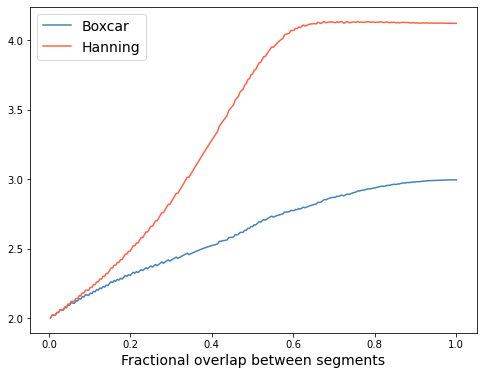

In [62]:
plt.figure(figsize=(8,6))
plt.plot(1-np.arange(0,Ns-1,2)/Ns, nu_boxcar[::2]/Nb_theory,
         color='steelblue', label='Boxcar')
plt.plot(1-np.arange(0,Ns-1,2)/Ns, nu_hanning[::2]/Nb_theory,
         color='tomato', label='Hanning')
plt.xlabel('Fractional overlap between segments', fontsize=14)
plt.legend(fontsize=14)

Figure 1: Ratio of degrees of freedom ν relative to nominal number of segments available if no overlapping is used for Hanning window and boxcar window.

**Filtering in the frequency domain**

Last time, when we talked about windowing, we noted that windowing in the time domain is
equivalent to convolution in the frequency
domain (and filtering in the time domain is equivalent to multiplication in the frequency
domain.)  This could lead you to an interesting conclusion.  What if you skipped all the
windowing and just did convolutions (i.e. filtering) in the frequency domain?  In the
limit in which you choose the same filter, these options should be the same.

This approach was originally developed by Daniell and is nicely discussed by von Storch and
Zwiers (see their section 12.3.11).  Daniell's original idea was to run a moving average
over the Fourier transform of the full record.  In this case the confidence intervals are
determined by:

$$\begin{equation}
P\left(\chi_{\nu,1-\alpha/2}^2 < \nu \frac{\hat E(f)}{E(f)} <
\chi_{\nu,\alpha/2}^2\right)
\end{equation}$$

where $\nu$ in this case is 2 $\times$ the number of frequencies averaged together.

The advantages of this approach are that it provides an unbiased estimate of the true spectrum.
The width of our averaging forces us to tradeoff bias (minimized if we do less averaging)
vs variance (minimized with more averaging).  One virtue of averaging in the frequency
domain is that we  can apply different levels of averaging (with different error bars)
depending on the frequency.